In [1]:
!pip install --upgrade pip --quiet

In [2]:
!pip install PyTDC

In [5]:

import os
import kagglehub
import zipfile
import json
from collections import Counter
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path

In [ ]:
base_path = Path('/content/drive/My Drive') / 'Chow, Khaira, Ranjan, Ryan - Capstone Project (Rx and Drug Combos)'

In [10]:
import seaborn as sns

In [8]:
import pandas as pd

# **Import TDC dataset**

In [3]:
from tdc.multi_pred import DDI

# Load data
data = DDI(name='DrugBank_DDI')
df = data.get_data()
df.head()


Downloading...
100%|██████████| 44.4M/44.4M [00:00<00:00, 50.3MiB/s]
Loading...
Done!


,Drug1_ID,Drug1,Drug2_ID,Drug2,Y
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
1,DB00855,NCC(=O)CCC(O)=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
2,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191808 entries, 0 to 191807
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Drug1_ID  191808 non-null  object
 1   Drug1     191808 non-null  object
 2   Drug2_ID  191808 non-null  object
 3   Drug2     191808 non-null  object
 4   Y         191808 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


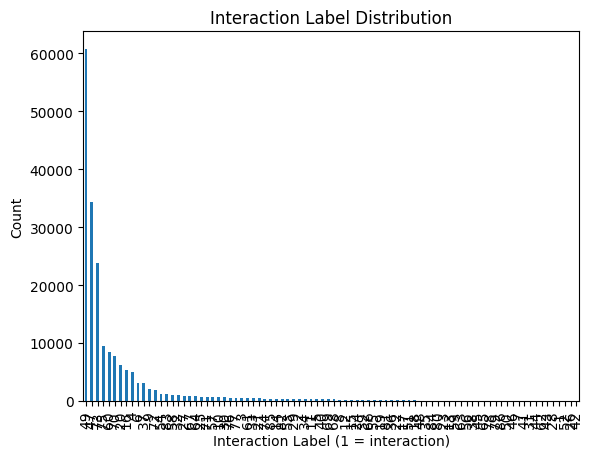

In [6]:
# Dataset info
df.info()

# Check class distribution
df['Y'].value_counts().plot(kind='bar', title='Interaction Label Distribution')
plt.xlabel('Interaction Label (1 = interaction)')
plt.ylabel('Count')
plt.show()


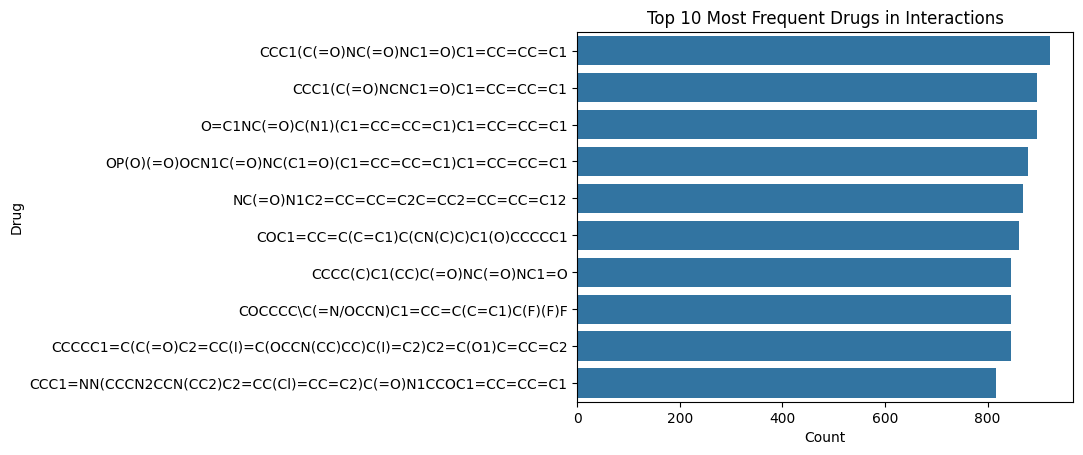

In [11]:
# Count drug frequency across both columns
all_drugs = df['Drug1'].tolist() + df['Drug2'].tolist()
drug_counts = Counter(all_drugs)

# Convert to DataFrame
drug_freq_df = pd.DataFrame(drug_counts.items(), columns=['Drug', 'Count']).sort_values(by='Count', ascending=False)

# Plot top 10
sns.barplot(x='Count', y='Drug', data=drug_freq_df.head(10))
plt.title('Top 10 Most Frequent Drugs in Interactions')
plt.show()


In [13]:
import requests

def get_pubchem_name(smiles):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/JSON"
        r = requests.get(url)
        return r.json()['PropertyTable']['Properties'][0]['IUPACName']
    except:
        return "Unknown"

# Apply to top 10 rows only for demo
top10 = drug_freq_df.head(10).copy()
top10['Drug_Name'] = top10['Drug'].apply(get_pubchem_name)


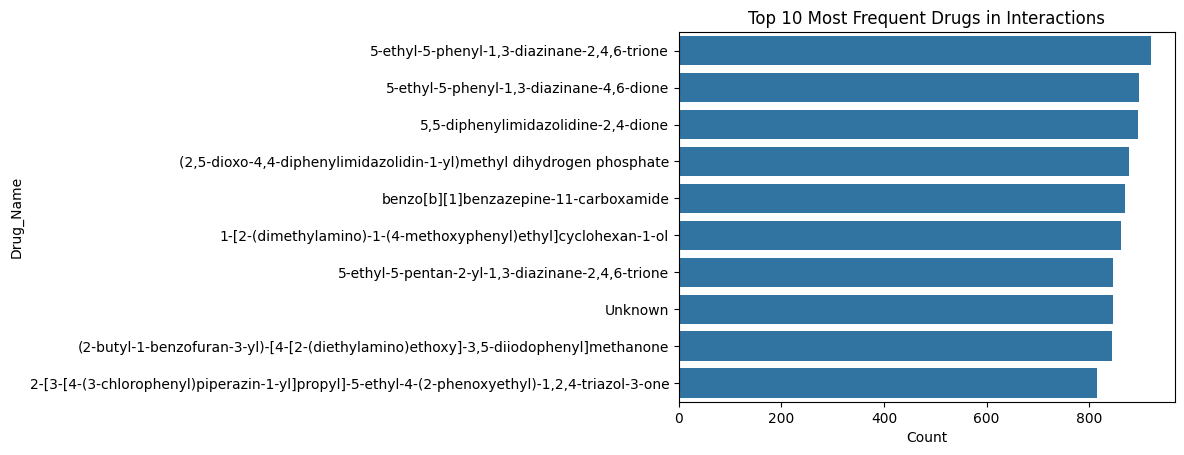

In [14]:
# Plot top 10
sns.barplot(x='Count', y='Drug_Name', data=top10)
plt.title('Top 10 Most Frequent Drugs in Interactions')
plt.show()

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(df[df['Y'] == 1], 'Drug1', 'Drug2')
plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(G.subgraph(list(drug_freq_df['Drug'][:10])), with_labels=True, node_color='lightblue')
plt.title('Network of Top Drug Interactions')
plt.show()


# **Import Kaggle dataset**

In [ ]:
##Path for kaggle dataset
path = kagglehub.dataset_download("mghobashy/drug-drug-interactions")

print("Path to dataset files:", path)

kaggle_drug = pd.read_csv(os.path.join(path, "db_drug_interactions.csv"))


In [ ]:
kaggle_drug.head(30)

In [ ]:
print(len(kaggle_drug))

# **National Library of Medicine Data**
https://dailymed.nlm.nih.gov/dailymed/spl-resources-all-mapping-files.cfm

In [ ]:
##All text files, didnt seem too important, uploaded to the folder in case

# **FDA Data**

In [ ]:
json_path = base_path/'Data/drug-drugsfda-0001-of-0001.json'
with open(json_path, 'r') as f:
    data = json.load(f)

##Has both resutls and meta data
results = data["results"]

fda = pd.json_normalize(results)

fda

In [ ]:
##exploding products
df_exploded = fda.explode("products")

products_df = pd.json_normalize(df_exploded["products"])

##combine
df_combined = pd.concat([df_exploded.drop(columns=["products"]).reset_index(drop=True),
                         products_df.reset_index(drop=True)], axis=1)

df_combined


In [ ]:
##Now exploding active ingrediants
df_ingredients_exploded = df_combined.explode("active_ingredients")

ingredients_df = pd.json_normalize(df_ingredients_exploded["active_ingredients"])

##combine
df_final_fda = pd.concat([df_ingredients_exploded.drop(columns=["active_ingredients"]).reset_index(drop=True),
                      ingredients_df.reset_index(drop=True)], axis=1)

##final from fda
print(df_final_fda.head())

df_final_fda


# **Hugging Face Dataset**

In [15]:
clinical_notes= pd.read_json("hf://datasets/AGBonnet/augmented-clinical-notes/augmented_notes_30K.jsonl", lines=True)

In [16]:
clinical_notes

,note,conversation,idx,summary,full_note
0,"A a sixteen year-old girl, presented to our Ou...","Doctor: Good morning, what brings you to the O...",155216,"{\n""visit motivation"": ""Discomfort in the neck...","A a sixteen year-old girl, presented to our Ou..."
1,This is the case of a 56-year-old man that was...,"Doctor: Hi, how are you feeling today?\nPatien...",77465,"{\n""visit motivation"": ""Complaints of a dull p...",This is the case of a 56-year-old man that was...
2,A 36-year old female patient visited our hospi...,"Doctor: Hello, what brings you to the hospital...",133948,"{\n""visit motivation"": ""Pain and restricted ra...",A 36-year old female patient visited our hospi...
3,A 49-year-old male presented with a complaint ...,"Doctor: Good morning, Mr. [Patient's Name]. I'...",80176,"{\n""visit motivation"": ""Pain in the left proxi...",A 49-year-old male presented with a complaint ...
4,A 47-year-old male patient was referred to the...,"Doctor: Good morning, how are you feeling toda...",72232,"{\n""visit motivation"": ""Recurrent attacks of p...",A 47-year-old male patient was referred to the...
...,...,...,...,...,...
29995,A 28-year-old male was admitted to the emergen...,"Doctor: Good morning, sir. Can you tell me wha...",39279,"{\n""visit motivation"": ""Stab wound under left ...",A 28-year-old male was admitted to the emergen...
29996,"An 82-year-old man (64.5 kg, 175 cm) diagnosed...","Doctor: Good morning, sir. I am Dr. John. How ...",137017,"{\n""visit motivation"": ""Diagnosed with falcine...","An 82-year-old man (64.5 kg, 175 cm) diagnosed..."
29997,A 54 year-old man with no past medical history...,"Doctor: Good morning, how are you feeling toda...",98004,"{\n""visit motivation"": ""Cardiac sounding chest...",A 54 year-old man with no past medical history...
29998,A 49-year-old woman visited the clinic due to ...,"Doctor: Good morning, how can I help you today...",133320,"{\n""visit motivation"": ""Mass in her right thig...",A 49-year-old woman visited the clinic due to ...


# **FINAL COLUMNS**

In [ ]:
df_final_fda.columns


In [17]:
clinical_notes.columns


Index(['note', 'conversation', 'idx', 'summary', 'full_note'], dtype='object')

In [ ]:
kaggle_drug.columns

# **EDA on FDA**

In [ ]:
#Flatten and count
flat_pharm_names = [name for sublist in df_final_fda["openfda.pharm_class_pe"].dropna() for name in sublist]

pharm_class_pe = Counter(flat_pharm_names)

##Count df
pharm_class_pe_df = pd.DataFrame(pharm_class_pe.items(), columns=["pharm_class", "count"]).sort_values(by="count", ascending=False)

print("Top 10 Pharmacologic Classes (Physiologic Effect):\n", pharm_class_pe_df.head(10))




In [ ]:
##Visualize
plt.figure(figsize=(10, 5))
pharm_class_pe_df.head(10).plot.bar(x="pharm_class", y="count", legend=False, title="Top 10 Pharmacologic Classes (PE)", color="mediumpurple")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
##Count values for binary flags
ref_drug_counts = df_final_fda["reference_drug"].value_counts(dropna=False)
ref_std_counts = df_final_fda["reference_standard"].value_counts(dropna=False)
marketing_status_counts = df_final_fda["marketing_status"].value_counts(dropna=False)

print("Reference Drug Flag Counts:\n", ref_drug_counts)
print("\nReference Standard Flag Counts:\n", ref_std_counts)
print("\nMarketing Status Distribution:\n", marketing_status_counts)


In [ ]:
##remove unexpected non-binary string
df_final_fda["reference_standard"] =  df_final_fda["reference_standard"].replace("ESOMEPRAZOLE MAGNESIUM", pd.NA)


In [ ]:
##Replace missing/NaN values
df_final_fda["marketing_status_clean"] = df_final_fda["marketing_status"].fillna("Unknown")

##Count
marketing_counts = df_final_fda["marketing_status_clean"].value_counts()

##Viusalise
plt.figure(figsize=(10, 5))
marketing_counts.plot(kind="bar", color="coral")
plt.title("Marketing Status Distribution")
plt.xlabel("Marketing Status")
plt.ylabel("Number of Drugs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# **EDA on clinical_notes**

In [18]:
##Length
print("Total rows:", len(clinical_notes))
print("Unique idx values:", len(set(clinical_notes['idx'])))


Total rows: 30000
Unique idx values: 30000


In [19]:
#Notes df
df_notes = pd.DataFrame(clinical_notes)

##length
df_notes["note_length"] = df_notes["note"].str.len()
df_notes["summary_length"] = df_notes["summary"].str.len()
df_notes["full_note_length"] = df_notes["full_note"].str.len()

print(df_notes[["note_length", "summary_length", "full_note_length"]].describe())


        note_length  summary_length  full_note_length
count  30000.000000    30000.000000      30000.000000
mean    2050.386533     3476.303200       3441.443667
std       91.738198      641.547313       1473.074268
min     1689.000000      864.000000        746.000000
25%     1988.000000     3050.000000       2456.000000
50%     2048.000000     3417.000000       3034.000000
75%     2111.000000     3840.000000       3953.000000
max     2445.000000     7904.000000      30995.000000


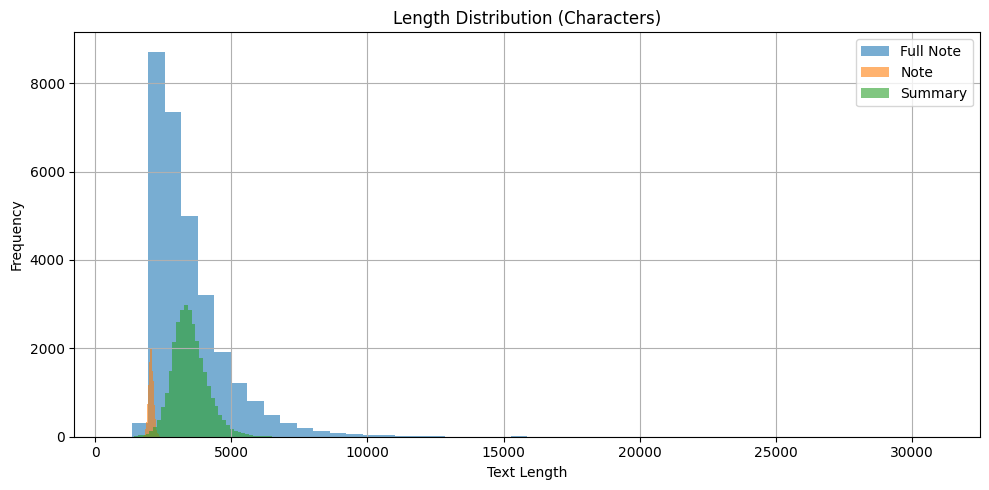

In [20]:
##Visualize
plt.figure(figsize=(10, 5))
df_notes["full_note_length"].hist(bins=50, alpha=0.6, label="Full Note")
df_notes["note_length"].hist(bins=50, alpha=0.6, label="Note")
df_notes["summary_length"].hist(bins=50, alpha=0.6, label="Summary")
plt.legend()
plt.title("Length Distribution (Characters)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [21]:
##key word analysis
#brianstorm
keywords = ["prescribed", "prescription", "tablet", "capsule", "medication", "drug", "mg", "dose", "take", "administer"]

#Combine into regex pattern (case-insensitive)
pattern = r"\b(" + "|".join(keywords) + r")\b"

#Apply to full_note (or note) column
df_notes["has_drug"] = df_notes["full_note"].str.contains(pattern, case=False, na=False)

#Count how many notes mention drugs
drug_mention_count = df_notes["has_drug"].sum()
print(f"🧾 Notes mentioning drugs/prescriptions: {drug_mention_count} / {len(df_notes)}")


🧾 Notes mentioning drugs/prescriptions: 14719 / 30000


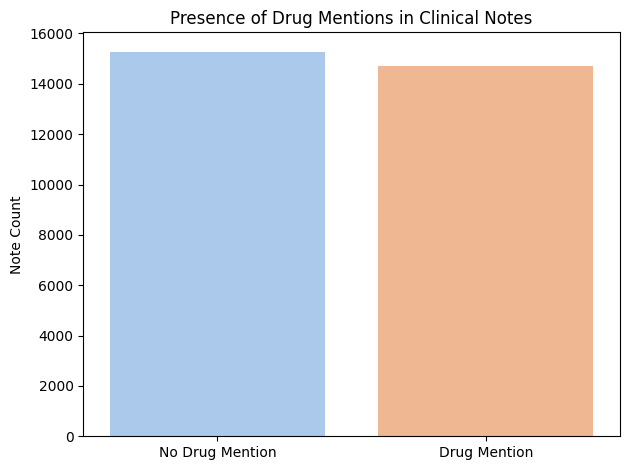

In [22]:
sns.countplot(x="has_drug", data=df_notes, palette="pastel")
plt.title("Presence of Drug Mentions in Clinical Notes")
plt.xticks([0, 1], ['No Drug Mention', 'Drug Mention'])
plt.ylabel("Note Count")
plt.xlabel("")
plt.tight_layout()
plt.show()

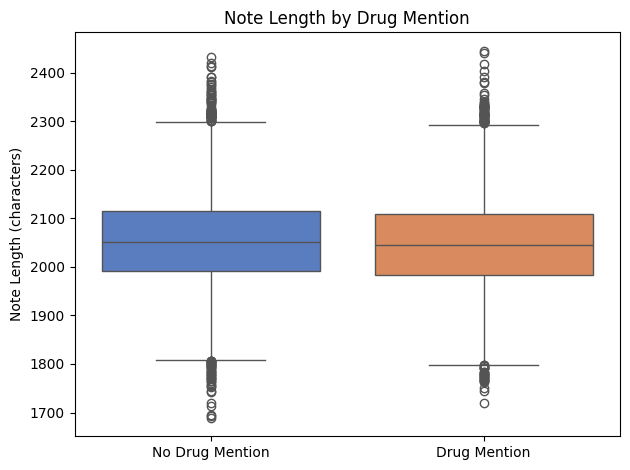

In [23]:
sns.boxplot(x="has_drug", y="note_length", data=df_notes, palette="muted")
plt.title("Note Length by Drug Mention")
plt.xticks([0, 1], ['No Drug Mention', 'Drug Mention'])
plt.ylabel("Note Length (characters)")
plt.xlabel("")
plt.tight_layout()
plt.show()


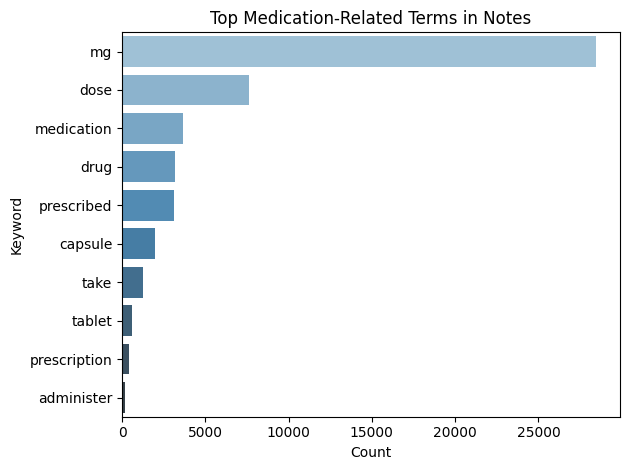

In [24]:
from collections import Counter
import re

# Extract all medication-like words (case insensitive)
all_matches = df_notes["full_note"].dropna().apply(lambda x: re.findall(pattern, x, flags=re.IGNORECASE)).sum()
counter = Counter([word.lower() for word in all_matches])
top_terms = pd.DataFrame(counter.most_common(10), columns=['Keyword', 'Count'])

sns.barplot(x="Count", y="Keyword", data=top_terms, palette="Blues_d")
plt.title("Top Medication-Related Terms in Notes")
plt.tight_layout()
plt.show()


# **Kaggle EDA**

In [ ]:
print("Total interactions:", len(kaggle_drug))


In [ ]:
##Count drugs
drug_counts = Counter(kaggle_drug['Drug 1']) + Counter(kaggle_drug['Drug 2'])

# Top 10
top_drugs = pd.DataFrame(drug_counts.items(), columns=['drug', 'interaction_count']).sort_values(by='interaction_count', ascending=False)
print(top_drugs.head(10))


In [ ]:
##visualize
top_drugs.head(10).plot.bar(x='drug', y='interaction_count', color='skyblue', title="Top 10 Most Interacting Drugs")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Interaction Count")
plt.tight_layout()
plt.show()


In [ ]:
##Common word analysis
kaggle_drug["interaction_lower"] = kaggle_drug["Interaction Description"].str.lower()

#Most common interaction
interaction_words = kaggle_drug["interaction_lower"].str.cat(sep=' ').split()
interaction_word_counts = Counter(interaction_words)
print("Top 20 common words in interaction descriptions:")
print(interaction_word_counts.most_common(20))
